![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importación librerías
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [46]:
y=dataTraining['Price']
X= dataTraining.drop('Price', axis=1)
Variables_numericas=['Year','Mileage','Model_Coded']
Variables_categoricas =['State','Make']
X

,Year,Mileage,State,Make,Model
0,2017,9913,FL,Jeep,Wrangler
1,2015,20578,OH,Chevrolet,Tahoe4WD
2,2012,83716,TX,BMW,X5AWD
3,2014,28729,OH,Cadillac,SRXLuxury
4,2013,64032,CO,Jeep,Wrangler
...,...,...,...,...,...
399995,2015,25287,TX,Lexus,RXRX
399996,2015,17677,MI,Chevrolet,EquinoxFWD
399997,2014,66688,NC,Buick,EnclaveLeather
399998,2014,37872,IN,Volkswagen,Jetta


In [47]:
frequencies = X['Model'].value_counts().reset_index()
frequencies.columns = ["Model", "frecuencia"]

# 
frequencies = frequencies.sort_values(by=["frecuencia"])
frequencies["Model_Coded"] = range(1, len(frequencies) + 1)

X_Coded = pd.merge(X,frequencies, on ='Model').drop(['Model','frecuencia'],axis=1)
X_Coded

,Year,Mileage,State,Make,Model_Coded
0,2017,9913,FL,Jeep,520
1,2013,64032,CO,Jeep,520
2,2011,75384,OH,Jeep,520
3,2014,56030,OK,Jeep,520
4,2014,21033,OK,Jeep,520
...,...,...,...,...,...
399995,2006,120400,VA,Mazda,1
399996,2009,92628,CA,Mazda,1
399997,2005,51202,TX,Mazda,1
399998,2008,111094,GA,Mazda,1


In [55]:
scaler = StandardScaler()
X_Coded_numericas_Scaled = scaler.fit_transform(X_Coded[Variables_numericas])

X_Coded_categoricas = X_Coded[Variables_categoricas].to_numpy()
X_Coded_categoricas,X_Coded_numericas_Scaled

Nombres_columnas = Variables_numericas+Variables_categoricas
X_Coded_Scaled = np.concatenate((X_Coded_numericas_Scaled, X_Coded_categoricas), axis=1)
X_Coded_Scaled = pd.DataFrame(X_Coded_Scaled, columns=Nombres_columnas)
X_Coded_Scaled

,Year,Mileage,Model_Coded,State,Make
0,1.15477,-1.104669,0.849344,FL,Jeep
1,-0.060178,0.219149,0.849344,CO,Jeep
2,-0.667652,0.496834,0.849344,OH,Jeep
3,0.243559,0.02341,0.849344,OK,Jeep
4,0.243559,-0.83266,0.849344,OK,Jeep
...,...,...,...,...,...
399995,-2.186337,1.597982,-3.778986,VA,Mazda
399996,-1.275126,0.918644,-3.778986,CA,Mazda
399997,-2.490074,-0.094688,-3.778986,TX,Mazda
399998,-1.578863,1.370345,-3.778986,GA,Mazda


In [57]:
Makes=X['Make'].drop_duplicates()
States= X['State'].drop_duplicates()

Makes.shape,Models.shape,States.shape
Variables_categoricas_escogidas = ['Make','State']
Variables_escogidas = Variables_categoricas_escogidas+Variables_numericas

X_Scaled_Coded_dummies=pd.get_dummies(X_Coded_Scaled,columns=Variables_categoricas_escogidas,drop_first=True)
X_Scaled_Coded_dummies

,Year,Mileage,Model_Coded,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,...,State_ SD,State_ TN,State_ TX,State_ UT,State_ VA,State_ VT,State_ WA,State_ WI,State_ WV,State_ WY
0,1.15477,-1.104669,0.849344,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.060178,0.219149,0.849344,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.667652,0.496834,0.849344,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.243559,0.02341,0.849344,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.243559,-0.83266,0.849344,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,-2.186337,1.597982,-3.778986,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
399996,-1.275126,0.918644,-3.778986,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
399997,-2.490074,-0.094688,-3.778986,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
399998,-1.578863,1.370345,-3.778986,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
p = X_Scaled_Coded_dummies.shape[1]

pca = PCA(n_components=p).fit(X_Scaled_Coded_dummies)
A=pca.components_
A.shape

(90, 90)

27


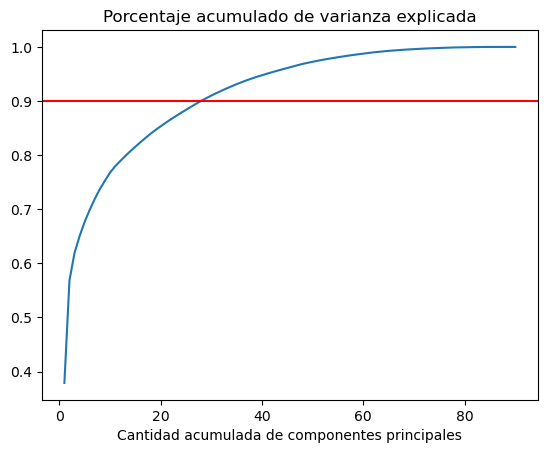

In [59]:
varianzaExplicada=pca.explained_variance_
porcentajeVarianzaExplicada=pca.explained_variance_ratio_
umbral = 0.9
plt.plot(range(1,p+1,1),np.cumsum(porcentajeVarianzaExplicada))
plt.xlabel('Cantidad acumulada de componentes principales')
plt.title('Porcentaje acumulado de varianza explicada')
plt.axhline(y=umbral,color='r')
nComponentesElegidas = np.sum(np.cumsum(porcentajeVarianzaExplicada) <= umbral)
print(nComponentesElegidas)
plt.show()

In [60]:
X_PCA_Scaled_Dummies =np.matmul(X_Scaled_Coded_dummies.to_numpy(),A)
X_PCA_Scaled_Dummies  = X_PCA_Scaled_Dummies[:,range(nComponentesElegidas)]
X_PCA_Scaled_Dummies

array([[0.003785494790173934, 1.0542571860271397, -1.4691773852806633,
        ..., -0.024651775913781197, 0.009156116577996368,
        0.06518337417504835],
       [0.6153733267633112, 0.6182934622300635, 0.16576972298028675, ...,
        0.040222282645775626, 0.013659505722813397,
        -0.027833985820772518],
       [0.9833780226578153, 0.29086309343160865, 0.6092831949621089, ...,
        -0.0031166400119770864, -0.009367013096514621,
        0.049866644931741214],
       ...,
       [-0.9648212767914356, -4.272869758052223, 0.9724577664137765, ...,
        0.028661179050039936, -0.0017366794463429197,
        0.04783145853682498],
       [-1.8280588191334397, -3.2665884281291118, 2.07782059867638, ...,
        0.17949158641801696, 0.04968767362974025, -0.06132691371764801],
       [-1.3359308175848075, -3.7955866053840275, 1.8205009812976993,
        ..., 0.04142649825480857, -0.00631274142617777,
        0.04591806053966777]], dtype=object)

In [133]:
XTrain, XTest, yTrain, yTest = train_test_split(X_PCA_Scaled_Dummies,y)


xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, gamma=0, subsample=0.7,
                           colsample_bytree=1, max_depth=5)
xgb_reg.fit(XTrain, yTrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [137]:
y_pred = xgb_reg.predict(XTest)
mse_xgboost = mean_squared_error(yTest, y_pred)
mae_xgboost = round(mean_absolute_error(yTest, y_pred),2)
r2_xgboost = round(r2_score(yTest, y_pred),3)

print("MSE: ", mse_xgboost)
print("R^2 Score:", r2_xgboost)
print("Mean Absolute Error (MAE):", mae_xgboost)
r2_xgboost = round(r2_score(yTest, y_pred),3)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_xgboost = round(mean_absolute_percentage_error(yTest, y_pred),2)
print("Mean Absolute Percentage Error (MAPE):", mape_xgboost, "%")

MSE:  54725583.23183123
R^2 Score: 0.527
Mean Absolute Error (MAE): 5438.57
Mean Absolute Percentage Error (MAPE): 28.75 %


In [138]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [6]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [7]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033
